In [1]:

import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2

from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16 

In [2]:
size=256
train_images=[]
train_labels=[]
for dir_path in glob.glob('/content/drive/MyDrive/datacov/train/*'):
  label=(dir_path.split('/')[-1])
  for file_path in glob.glob(os.path.join(dir_path,"*.png")):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (size,size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
    train_labels.append(label)
train_images=np.array(train_images)
train_labels=np.array(train_labels)    


In [3]:
size=256
test_images=[]
test_labels=[]
for dir_path in glob.glob('/content/drive/MyDrive/datacov/val/*'):
  label=(dir_path.split('/')[-1])
  for file_path in glob.glob(os.path.join(dir_path,"*.png")):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (size,size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images.append(img)
    test_labels.append(label)
test_images=np.array(test_images)
test_labels=np.array(test_labels)   

In [4]:
print(train_images.shape)
print(test_images.shape)

(2232, 256, 256, 3)
(249, 256, 256, 3)


In [5]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(train_labels)
print(train_labels_encoded)

['no_covid' 'no_covid' 'no_covid' ... 'covid' 'covid' 'covid']
[1 1 1 ... 0 0 0]


In [6]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [7]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(size,size, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [10]:
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features

In [11]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [13]:
prediction = model.predict(X_test_features) 

In [14]:
prediction = le.inverse_transform(prediction)
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.9357429718875502


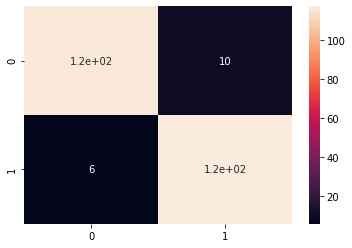

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction)
sns.heatmap(cm, annot=True)

Orginal output: covid
Model predicted output: covid


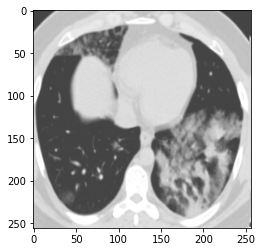

In [16]:
plt.imshow(test_images[189])
print('Orginal output: {}'.format(test_labels[189]))
img=np.expand_dims(test_images[189],axis=0)
test_feature= VGG_model.predict(img)
test_features=test_feature.reshape(test_feature.shape[0],-1)
prediction_test=model.predict(test_features) 
print('Model predicted output: {}' .format(le.inverse_transform(prediction_test)[0]))



In [17]:
#Random search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [18]:
model1= xgb.XGBClassifier()
random_search=RandomizedSearchCV(model1,param_distributions=params,n_iter=3,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X_for_training, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 22.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           verbosity=1),
                   iid='deprecated', n_iter=3, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0

In [20]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3,
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:

model1=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3,
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


model1.fit(X_for_training, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3,
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
prediction = model1.predict(X_test_features) 

In [23]:
prediction = le.inverse_transform(prediction)
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.9518072289156626


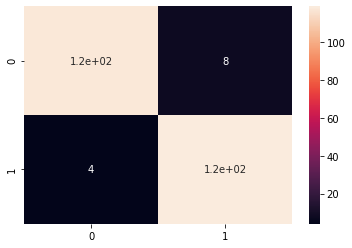

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction)
sns.heatmap(cm, annot=True)